### Shadow State Tomography

During state tomography we reconstruct density matrix, which corresponds to “original circuit”.

We build a list of “measurement circuits” which perform rotation of measurement bases.

Then we compare 2 types of transpilation:

- **Basic Transpilation:** every “measurement circuit” is composed to “original circuit” – and then composed circuit is transpiled.

- **Transpile Right:** we transpile “original circuit” only once – and then use “transpile_right” function of QML Transpiler – to transpile only “measurement circuit” part.

Since “measurement circuit” is much smaller than “original circuit” – “Transpile Right” approach is expected to be much faster.

In [1]:
# https://github.com/ryanlevy/shadow-tutorial/blob/main/Tutorial_Shadow_State_Tomography.ipynb

### Imports

In [2]:
import numpy as np

from time import time
from tqdm import tqdm

import qiskit

from qiskit.providers.aer import AerSimulator

from qiskit.providers.fake_provider import FakeBackend5QV2
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.providers.fake_provider import FakeMontrealV2
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.providers.fake_provider import FakeBoeblingenV2

from qiskit.circuit.random import random_circuit

import matplotlib.pyplot as plt

plt.style.use("dark_background")

%cd ../..

from qml_transpiler import transpile_right

/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler


### Functions

In [3]:
def get_ghz_circuit(qubits_count):
    
    qubits = list(range(qubits_count))
    
    circuit = qiskit.QuantumCircuit(qubits_count)
    
    circuit.h(0)
    
    for control, target in zip(qubits, qubits[1:]):
    
        circuit.cx(control, target)
        
    return circuit

In [4]:
def rotate_qubit_to_basis(circuit, qubit, basis):
    
    if basis == "X":
        circuit.h(qubit)
        
    elif basis == "Y":
        circuit.sdg(qubit)
        circuit.h(qubit)
        
    elif basis == "Z":
        pass

In [5]:
def build_bases_rotation_circuit(bases):
    
    qubits_count = len(bases)
    
    circuit = qiskit.QuantumCircuit(qubits_count)
    
    for qubit, basis in enumerate(bases):
        
        if basis == "X":
            circuit.h(qubit)
        
        elif basis == "Y":
            circuit.sdg(qubit)
            circuit.h(qubit)
        
        elif basis == "Z":
            pass
        
    return circuit

In [6]:
def get_inverted_channel(channel, qubits_count):
    
    identity = np.eye(2 ** qubits_count)
    
    inverted_channel = (2 ** qubits_count + 1) * channel - identity
    
    return inverted_channel

In [7]:
def get_basis_unitary(basis):
    
    if basis == "X":
        unitary = 1/np.sqrt(2) * np.array([[1.,1.],
                                           [1.,-1.]])
    elif basis == "Y":
        unitary = 1/np.sqrt(2) * np.array([[1.,-1.0j],
                                           [1.,1.j]])
    elif basis == "Z":
        unitary = np.eye(2)
        
    return unitary

In [8]:
def get_mean_square_error(a, b):

    mean_square_error = np.abs(((a - b) ** 2).mean())
    
    return mean_square_error

### Backend

In [9]:
# FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
FAKE_BACKEND = FakeMontrealV2()

backend = AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Parameters

In [10]:
QUBITS_COUNT = 3
SU2_LAYERS_COUNT = 10
PARAMETRIZATION_RATIO = 0.25

OPTIMIZATION_LEVEL = 3

SEED = 1234

In [11]:
qubits = list(range(QUBITS_COUNT))

rng = np.random.default_rng(SEED)

### Parametrized SU2 Circuit

In [12]:
# Non-Parametrized Part

left_part = qiskit.QuantumCircuit(QUBITS_COUNT)
right_part = qiskit.QuantumCircuit(QUBITS_COUNT)

non_parametrized_layers_count = SU2_LAYERS_COUNT * 2 * (1 / PARAMETRIZATION_RATIO - 1)

non_parametrized_layers_count = int(non_parametrized_layers_count)

for left_layer in range(non_parametrized_layers_count // 2):
    left_part.rz(0.5, qubits)
    
for right_layer in range(non_parametrized_layers_count // 2):
    right_part.rz(1.5, qubits)   
    
# Parametrized Part

parametrized_part = qiskit.circuit.library.EfficientSU2(
    num_qubits=QUBITS_COUNT,
    reps=SU2_LAYERS_COUNT,
    entanglement="linear",
    skip_final_rotation_layer=True
)

# Compose Parts

parametrized_part = parametrized_part.decompose()

parametrized_circuit = parametrized_part.compose(left_part, front=True)
parametrized_circuit = parametrized_circuit.compose(right_part)

# parametrized_circuit.measure_all()

# display(parametrized_circuit.draw(fold=-1))

# Bind Parameters

random_parameters = np.random.rand(parametrized_circuit.num_parameters)

circuit = parametrized_circuit.bind_parameters(random_parameters)

print("circuit.depth():", circuit.depth())

# circuit.draw(fold=-1)

circuit.depth(): 100


### Other Circuits

In [13]:
# # GHZ Circuit

# circuit = get_ghz_circuit(QUBITS_COUNT)

# # Random Circuit

# circuit = random_circuit(QUBITS_COUNT, depth=20, max_operands=1, measure=False)

# # circuit.draw(fold=-1)

## 1) Paulis

In [14]:
TOTAL_SHOTS_COUNT = 1000

### Bases

In [15]:
random_bases = rng.choice(['X','Y','Z'], size=(TOTAL_SHOTS_COUNT, QUBITS_COUNT))
          
bases_list, shots_counts = np.unique(random_bases, axis=0, return_counts=True)

bases_list.shape

(27, 3)

### Rotation Circuits

In [16]:
rotation_circuits = []

for bases in bases_list:
        
    rotation_circuit = build_bases_rotation_circuit(bases)
    
    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

27

### Basic Transpilation - Slower one!

In [17]:
start_time = time()


# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:
    
    measurement_circuit = rotation_circuit.measure_all(inplace=False)
    
    measured_circuit = circuit.compose(measurement_circuit)
    
    # display(measured_circuit.draw(fold=-1))
    
    shadow_circuit = qiskit.transpile(
        measured_circuit, 
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)
    
    shadow_circuits.append(shadow_circuit)
    
estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.20 basis/s]

estimated_time: 3.30


### Transpile Right - Much faster!

In [18]:
start_time = time()

# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit, 
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []
    
rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:
    
    measurement_circuit = rotation_circuit.measure_all(inplace=False)
    
    shadow_circuit = transpile_right(
        transpiled_central_circuit, 
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)    
    
    shadow_circuits.append(shadow_circuit)
    

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 61.18 basis/s]

estimated_time: 0.56


### Run Shadow Circuits

In [19]:
counts_list = []

for shadow_circuit, shots in zip(shadow_circuits, shots_counts):

    job = backend.run(shadow_circuit, shots=shots)

    counts = job.result().get_counts()

    counts_list.append(counts)

### Calculate Shadows

In [20]:
shadows = []

for bases, counts in zip(bases_list, counts_list):
    
    for state, count in counts.items():
            
        shadow_part = 1
        
        for bit_index, bit in enumerate(state[::-1]):
            
            basis = bases[bit_index]
            
            basis_unitary = get_basis_unitary(basis)
            
            vector = basis_unitary[int(bit), :]
            
            outer_product = np.outer(vector.conj(), vector)
            
            inverted_channel = get_inverted_channel(outer_product, 1)
            
            shadow_part = np.kron(inverted_channel, shadow_part)
            
        shadow = shadow_part * count
            
        shadows.append(shadow)

### Density Matrices

In [21]:
reconstructed_density_matrix = np.sum(shadows, axis=0) / TOTAL_SHOTS_COUNT

reconstructed_density_matrix.shape

(8, 8)

In [22]:
original_density_matrix = qiskit.quantum_info.DensityMatrix(circuit).data

original_density_matrix.shape

(8, 8)

### Plot Density Matrices

In [23]:
def plot_density_matrix(density_matrix, label=""):

    plt.suptitle(f"{label} Density Matrix", y=0.9)

    real = plt.subplot(121)
    real.set_title("Real part")

    real.imshow(density_matrix.real, vmin=-0.7, vmax=0.7)

    real.axes.set_xticks(())
    real.axes.set_yticks(())


    imaginary = plt.subplot(122)
    imaginary.set_title("Imaginary part")
    imaginary.imshow(density_matrix.imag, vmin=-0.7, vmax=0.7)

    imaginary.axes.set_xticks(())
    imaginary.axes.set_yticks(())

    plt.show()

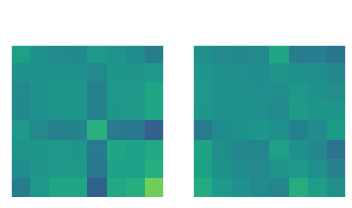

In [24]:
plot_density_matrix(original_density_matrix, label="Original")

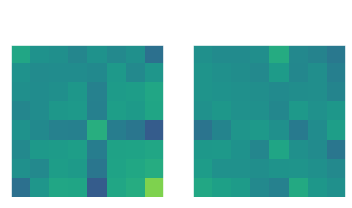

In [25]:
plot_density_matrix(reconstructed_density_matrix, label="Reconstructed")

### Mean Square Error

In [26]:
mean_square_error = np.abs(((original_density_matrix - 
                             reconstructed_density_matrix) ** 2).mean())

mean_square_error

2.5875502179626467e-05

## 2) Cliffords

In [27]:
SHADOWS_COUNT = 100
SHOTS_COUNT = 100

cliffords = [qiskit.quantum_info.random_clifford(QUBITS_COUNT, seed=rng) 
             for _ in range(SHADOWS_COUNT)]

### Rotation Circuits

In [28]:
rotation_circuits = []

for clifford in cliffords:
        
    rotation_circuit = clifford.to_circuit()
    
    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

100

### Basic Transpilation - Slower one!

In [29]:
start_time = time()


# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:
    
    measurement_circuit = rotation_circuit.measure_all(inplace=False)
    
    measured_circuit = circuit.compose(measurement_circuit)
    
    # display(measured_circuit.draw(fold=-1))
    
    shadow_circuit = qiskit.transpile(
        measured_circuit, 
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)
    
    shadow_circuits.append(shadow_circuit)
    
estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.26 basis/s]

estimated_time: 15.98


### Transpile Right - Much faster!

In [30]:
start_time = time()

# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit, 
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []
    
rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:
    
    measurement_circuit = rotation_circuit.measure_all(inplace=False)
    
    shadow_circuit = transpile_right(
        transpiled_central_circuit, 
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)    
    
    shadow_circuits.append(shadow_circuit)
    

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.78 basis/s]

estimated_time: 3.86


### Run Shadow Circuits

In [31]:
counts_list = []

for shadow_circuit in shadow_circuits:

    job = backend.run(shadow_circuit, shots=SHOTS_COUNT)

    counts = job.result().get_counts()

    counts_list.append(counts)

### Calculate Shadows

In [32]:
shadows = []

for clifford, counts in zip(cliffords, counts_list):
    
    unitary = clifford.adjoint().to_matrix()
    
    for state, count in counts.items():
        
        state_index = int(state, 2)
        
        vector = unitary[:, state_index]
        
        outer_product = np.outer(vector, vector.conj())
        
        inverted_channel = get_inverted_channel(outer_product, QUBITS_COUNT)
        
        shadow = inverted_channel * count
        
        shadows.append(shadow)

### Density Matrices

In [33]:
TOTAL_SHOTS_COUNT = SHADOWS_COUNT * SHOTS_COUNT

reconstructed_density_matrix = np.sum(shadows, axis=0) / TOTAL_SHOTS_COUNT

reconstructed_density_matrix.shape

(8, 8)

In [34]:
original_density_matrix = qiskit.quantum_info.DensityMatrix(circuit).data

original_density_matrix.shape

(8, 8)

### Plot Density Matrices

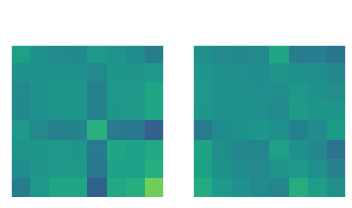

In [35]:
plot_density_matrix(original_density_matrix, label="Original")

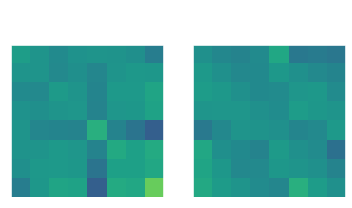

In [36]:
plot_density_matrix(reconstructed_density_matrix, label="Reconstructed")

In [37]:
get_mean_square_error(original_density_matrix,
                      reconstructed_density_matrix)

0.00023494108577053774

## 3) Plot Transpilation Times

In [38]:
results = np.load("examples/shadows/results.npy",
                  allow_pickle=True).item()
results

{2: {'bases': 9, 'basic_transpilation': 2.15, 'transpile_right': 0.27},
 3: {'bases': 27, 'basic_transpilation': 20.03, 'transpile_right': 1.14},
 4: {'bases': 81, 'basic_transpilation': 82.06, 'transpile_right': 2.74},
 5: {'bases': 243, 'basic_transpilation': 312.58, 'transpile_right': 7.39},
 6: {'bases': 729, 'basic_transpilation': 1150.28, 'transpile_right': 23.47},
 7: {'bases': 2167, 'basic_transpilation': 3939.58, 'transpile_right': 121.01},
 8: {'bases': 5127,
  'basic_transpilation': 10018.36,
  'transpile_right': 271.09}}

In [39]:
basic_times = [results[qubit_count]['basic_transpilation'] for qubit_count in results]

basic_times

[2.15, 20.03, 82.06, 312.58, 1150.28, 3939.58, 10018.36]

In [40]:
right_times = [results[qubit_count]['transpile_right'] for qubit_count in results]

right_times

[0.27, 1.14, 2.74, 7.39, 23.47, 121.01, 271.09]

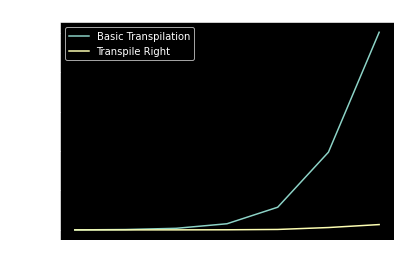

In [41]:
# Plot Transpilation times

qubit_counts = list(results.keys())

plt.title("Transpilation time comparison")
plt.xlabel("Qubits")
plt.ylabel("Transpilation time, seconds")

plt.plot(qubit_counts, basic_times, label="Basic Transpilation")
plt.plot(qubit_counts, right_times, label="Transpile Right")

plt.legend()

plt.show()

### Conclusions

For parametrized SU2 with depth 1000:

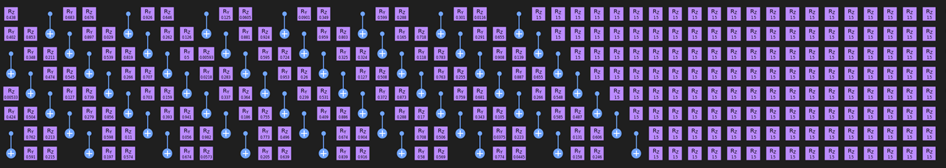

"Transpile Right" shows much better results than "Basic Transpilation":

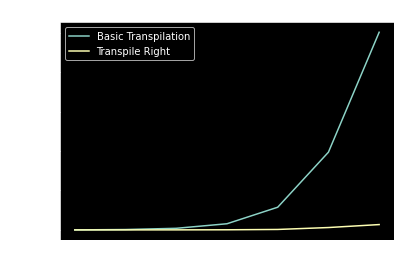

\* Transpilation time in milliseconds